In [1]:
from uproot_io import Events, View
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt

filename = r"C:\Users\red20\Documents\Physics_Project\projects\CheatedRecoFile_1.root"
events = Events(filename)

from variables import *
from ROC import *
from PLOT import *

import pandas as pd 
file = r"C:\Users\red20\Documents\Physics_Project\data.csv"
particle = pd.read_csv(file)

In [2]:
minhits = 7

protons_idx = pdg_idx(events,2212,minhits,1)
pion_plus = pdg_idx(events,211,minhits,1)
pion_minus = pdg_idx(events,-211,minhits,1)
muon_plus = pdg_idx(events,13,minhits,1)
muon_minus = pdg_idx(events,-13,minhits,1) 

tracks_idx = np.concatenate((protons_idx,pion_plus,pion_minus,muon_plus,muon_minus))

electron_idx = pdg_idx(events,-11,minhits,1)
positron_idx = pdg_idx(events,11,minhits,1)
gamma_idx = pdg_idx(events,22,minhits,1)

showers_idx = np.concatenate((gamma_idx,positron_idx,electron_idx))

In [3]:
rms_w = particle["rms_w"]
rms_v = particle["rms_v"]
rms_u = particle["rms_u"]

tracks_rms_w = [rms_w[i] for i in tracks_idx]
showers_rms_w = [rms_w[i] for i in showers_idx]

tracks_rms_v = [rms_v[i] for i in tracks_idx]
showers_rms_v = [rms_v[i] for i in showers_idx]

tracks_rms_u = [rms_u[i] for i in tracks_idx]
showers_rms_u = [rms_u[i] for i in showers_idx]

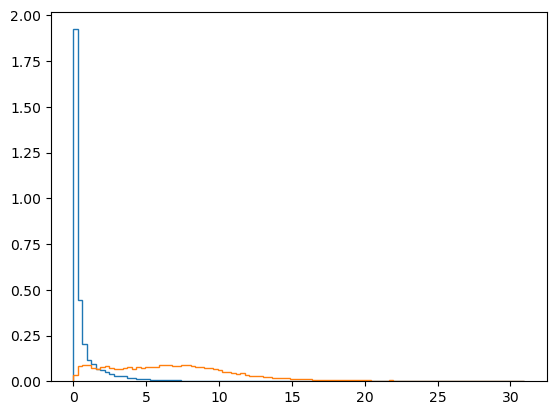

In [4]:
plot_hist(tracks_rms_w,showers_rms_w,100,4)

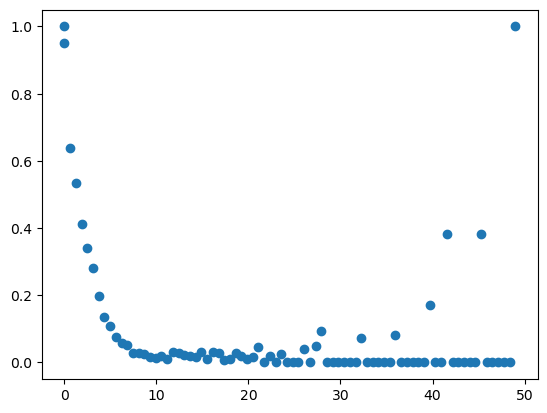

In [22]:
def prob_var(tr,sh,bins):
    max_tr = max(tr)
    max_sh = max(sh)
    min_tr = min(tr)
    min_sh = min(sh)
    
    T_prob = np.array([])
    S_prob = np.array([])
    
    #if max_tr > max_sh:
    #    bins_array =np.concatenate(([min_tr],[min_sh + i*((max_tr-min_sh)/bins) for i in range(bins)],[max_tr]))
    #else:
    #    bins_array =np.concatenate(([min_tr],[min_sh + i*((max_tr-min_sh)/bins) for i in range(bins)],[max_tr,max_sh]))

    bins_array =np.concatenate(([min_tr],[min_sh + i*((max_tr-min_sh)/bins) for i in range(bins+1)]))
    tr_pdf = np.histogram(tr,bins=bins_array,density=True)[0]
    sh_pdf = np.histogram(sh,bins=bins_array,density=True)[0]

    for i in range(np.size(bins_array)-1):
        if (tr_pdf[i] == 0):
            T_prob = np.append(T_prob,0)
            S_prob = np.append(S_prob,1)
        elif (sh_pdf[i] == 0):
            T_prob = np.append(T_prob,1)
            S_prob = np.append(S_prob,0)
        else:
            T_prob = np.append(T_prob,tr_pdf[i]/(sh_pdf[i]+tr_pdf[i]))
            S_prob = np.append(S_prob,sh_pdf[i]/(sh_pdf[i]+tr_pdf[i]))

    return T_prob,S_prob,bins_array

bins = 80
P_tr = prob_var(tracks_rms_w,showers_rms_w,bins)[0]
P_sh = prob_var(tracks_rms_w,showers_rms_w,bins)[1]
b = prob_var(tracks_rms_w,showers_rms_w,bins)[2]

plt.scatter(b[:-1],P_tr)

In [23]:
training = 0.75
tr_training = tracks_rms_u[:int(training*np.size(tracks_rms_u))]
sh_training = showers_rms_u[:int(training*np.size(showers_rms_u))]

print(min(tr_training),max(tr_training))
print(min(sh_training),max(sh_training))

#prob_var(tr_training,sh_training,100)

0.0041789514892348 96.35678814607246
0.0219429603974758 90.8045670288188


In [24]:
def L_var(tr,sh,type):
    training = 0.75
    tr_training = tr[:int(training*np.size(tr))]
    sh_training = sh[:int(training*np.size(sh))]
    tr_test = tr[int(training*np.size(tr)):]
    sh_test = tr[int(training*np.size(sh)):]
    tr_test_prob = np.array([])
    sh_test_prob = np.array([])
    
    bins = 80
    T_prob = prob_var(tr_training,sh_training,bins)[0]
    S_prob = prob_var(tr_training,sh_training,bins)[1]
    bins_array = prob_var(tr_training,sh_training,bins)[2]
    
    if type == "s":
        for i in tr_test:
            if i < bins_array[0]:
                tr_test_prob = np.append(tr_test_prob,1)
                sh_test_prob = np.append(sh_test_prob,0)
            if i > bins_array[-1]:
                tr_test_prob = np.append(tr_test_prob,0)
                sh_test_prob = np.append(sh_test_prob,1)
            else:
                for j in range(np.size(bins_array)-1):
                    if bins_array[j] < i < bins_array[j+1]:
                        tr_test_prob = np.append(tr_test_prob,T_prob[j])
                        sh_test_prob = np.append(sh_test_prob,S_prob[j])
        return tr_test_prob,sh_test_prob

    if type == "t":
        for i in sh_test:
            if i < bins_array[0]:
                tr_test_prob = np.append(tr_test_prob,1)
                sh_test_prob = np.append(sh_test_prob,0)
            if i > bins_array[-1]:
                tr_test_prob = np.append(tr_test_prob,0)
                sh_test_prob = np.append(sh_test_prob,1)
            else:
                for j in range(np.size(bins_array)-1):
                    if bins_array[j] < i < bins_array[j+1]:
                        tr_test_prob = np.append(tr_test_prob,T_prob[j])
                        sh_test_prob = np.append(sh_test_prob,S_prob[j])
        return tr_test_prob,sh_test_prob

    


In [26]:
Tu_asT, Su_asT = L_var(tracks_rms_u,showers_rms_u,"t")[0], L_var(tracks_rms_u,showers_rms_u,"t")[1]
Tv_asT, Sv_asT = L_var(tracks_rms_v,showers_rms_v,"t")[0], L_var(tracks_rms_v,showers_rms_v,"t")[1]
Tw_asT, Sw_asT = L_var(tracks_rms_w,showers_rms_w,"t")[0], L_var(tracks_rms_w,showers_rms_w,"t")[1]

Tw_asT = np.append(Tw_asT,0.9)
Sw_asT = np.append(Sw_asT,0.9)



In [29]:
Tu_asS, Su_asS = L_var(tracks_rms_u,showers_rms_u,"s")[0], L_var(tracks_rms_u,showers_rms_u,"s")[1]
Tv_asS, Sv_asS = L_var(tracks_rms_v,showers_rms_v,"s")[0], L_var(tracks_rms_v,showers_rms_v,"s")[1]
Tw_asS, Sw_asS = L_var(tracks_rms_w,showers_rms_w,"s")[0], L_var(tracks_rms_w,showers_rms_w,"s")[1]

Tw_asS = np.append(Tw_asT,0.9)
Sw_asS = np.append(Sw_asT,0.9)

LS_tr = Tu_asS*Tv_asS*Tw_asS
LS_sh = Su_asS*Sv_asS*Sw_asS

L_bck = [LS_tr[i]/(LS_tr[i]+LS_sh[i]) for i in range(np.size(LS_tr))]

ValueError: operands could not be broadcast together with shapes (6712,) (14409,) 

C:\Users\red20\AppData\Local\Temp\ipykernel_2440\1886863464.py:4: RuntimeWarning: invalid value encountered in double_scalars
  L_sig = [LT_tr[i]/(LT_tr[i]+LT_sh[i]) for i in range(np.size(LT_tr))]


(array([1.035e+03, 2.640e+02, 1.760e+02, 9.200e+01, 1.320e+02, 1.140e+02,
        4.900e+01, 1.080e+02, 2.700e+01, 1.050e+02, 1.100e+01, 1.020e+02,
        5.500e+01, 6.300e+01, 3.000e+01, 1.500e+01, 6.000e+00, 1.100e+01,
        6.600e+01, 1.400e+01, 7.000e+00, 8.300e+01, 9.000e+00, 1.900e+01,
        4.800e+01, 1.400e+01, 3.000e+00, 1.180e+02, 8.000e+00, 3.700e+01,
        1.100e+01, 4.000e+00, 3.100e+01, 2.000e+00, 1.000e+01, 8.000e+00,
        2.000e+00, 6.000e+00, 1.800e+01, 0.000e+00, 6.000e+00, 6.000e+00,
        4.800e+01, 1.600e+01, 3.200e+01, 4.900e+01, 5.000e+00, 1.790e+02,
        7.000e+00, 1.700e+01, 5.000e+00, 1.200e+01, 3.800e+01, 2.000e+00,
        8.000e+00, 1.600e+01, 6.000e+00, 3.300e+01, 3.300e+01, 1.200e+01,
        5.000e+00, 1.100e+01, 7.000e+00, 2.000e+00, 0.000e+00, 4.000e+01,
        2.100e+01, 6.700e+01, 2.500e+01, 1.200e+01, 1.380e+02, 1.100e+01,
        1.000e+01, 1.000e+01, 1.000e+01, 4.300e+01, 3.000e+00, 5.000e+00,
        1.000e+00, 1.700e+01, 1.320e+0

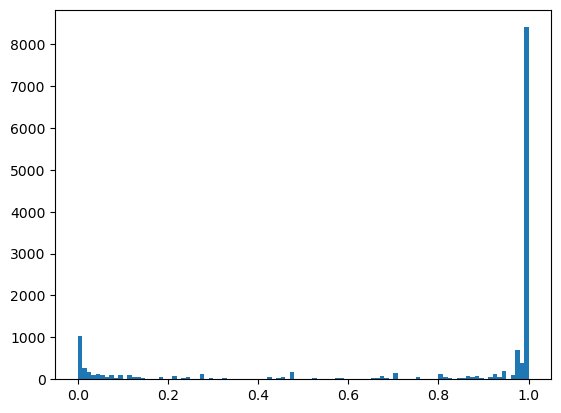

In [27]:
LT_tr = Tu_asT*Tv_asT*Tw_asT
LT_sh = Su_asT*Sv_asT*Sw_asT


L_sig = [LT_tr[i]/(LT_tr[i]+LT_sh[i]) for i in range(np.size(LT_tr))]

plt.hist(L_sig,100,density=Tr)